# PCA: data compression and online learning

This problem sheet explores applications of batch and online PCA. The first exercise shows
how (batch) PCA can be used for compressing data. The second exercise demonstrates how the
first principal direction can be found with a simple iterative algorithm (Oja's Rule) and the third
exercise applies it to online-learning.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from PIL import Image
import pandas as pd

## 3.1 Data compression (3 points)
Choose a portion of an arbitrary image from the image database (`imgpca.zip` – used also on
the previous exercise sheet) and reconstruct it using only the first $n$ PCs for $n \in \{1, 2, 4, 8, 16, 100\}$.
To this end,


1. take a subportion of e.g. $160 \times 320$ pixels of the chosen image and partition it into $10 \times 20$ tiles.
2. Calculate the PCs for this small dataset
3. Reconstruct the tiles using only the first $n$ components
4.  After reconstructing the tiles, stitch them back together and plot the reconstructed image. Compute the squared error between the reconstruction and the original image.
5. Using the PCs from this image, reconstruct an image region of the same size from a different picture.

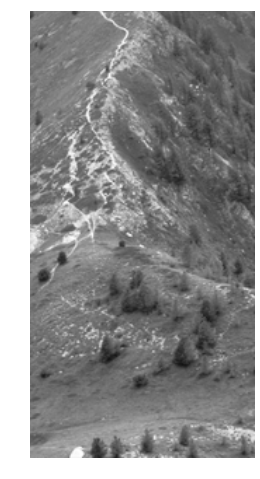

In [5]:
# (a)
img = Image.open("imgpca/n9.jpg")
matrix = []
for y in xrange(16):
    for x in xrange(16):
        matrix.append(list(img.crop((x*10,y*20,x*10+10,y*20+20)).getdata()))
matrix = np.array(matrix)

def reconstruct_pixels(tiles):
    pixels = np.empty((320,160))
    for y in xrange(16):
        for x in xrange(16):
            tile = np.reshape(tiles[16*y+x], (-1,10))
            pixels[y*20:y*20+20,x*10:x*10+10] = tile
    return pixels

fig, ax = plt.subplots(figsize=(4,8))
ax = plt.imshow(reconstruct_pixels(matrix), cmap=cm.Greys_r, vmin=0, vmax=255)
plt.axis("off")
plt.show()
plt.close()
matrix_save = matrix

In [6]:
# (b)
matrix = matrix_save.copy().astype(float)
p = 256
N = 200
matrix -= np.mean(matrix, axis=0)
cov = np.dot(matrix.T, matrix) / (p-1)
vals, vecs = np.linalg.eig(cov)
# sort
idx = vals.argsort()[::-1]
vals = vals[idx]
vecs = vecs[:,idx]

In [7]:
# (c)
pcs = [1,2,4,8,16,100,200]

def reconstruct_image(data, n) :
    re = np.zeros((p,N))
    for i in range(p) :
        x = data[i]
        for pc in range(n) :
            e = vecs[pc]
            a = np.dot(x.T,e)
            re[i] += a*e
        diff = (x -  re[i])
        error = (diff*diff).sum()
    return (re, error)

def normalize_image(data, re) :
    img_range = data.max()
    rmin = re.min()
    rmax = re.max()
    for i in range(p) :
        for j in range(N) :
            re[i][j] = img_range * (re[i][j] - rmin) / (rmax - rmin)

def create_reconstructed_matrixes_and_erros(data) :
    re_data = []
    errors = []
    # for each n
    for n in pcs :
        (re, error) = reconstruct_image(data, n)
        errors.append(error)
        normalize_image(data, re)
        re_data.append(re)
    return (re_data, errors)

matrix = matrix_save.copy().astype(float)
(re_matrices, errors) = create_reconstructed_matrixes_and_erros(matrix)

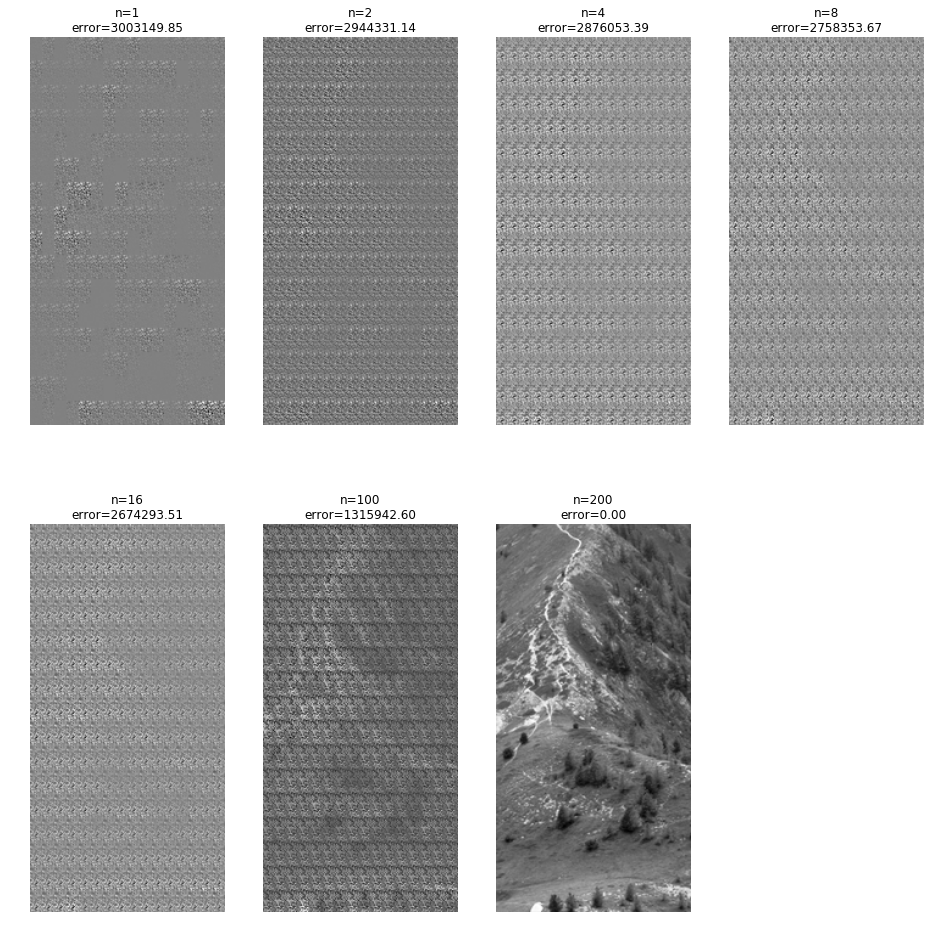

In [8]:
# (d)
def show_reconstruct_evolution(re_data, errors) :
    fig = plt.figure(figsize=(16, 16))
    ax = []
    images = []
    for i in range(len(re_data)) :
        a = fig.add_subplot(2,4,i+1)
        a.set_title("n="+str(pcs[i])+"\nerror="+"{0:.2f}".format(errors[i]))
        images.append(a.imshow(reconstruct_pixels(re_data[i]), 
                               cmap = cm.Greys_r, vmin=0, vmax=255))
        ax.append(a)
        plt.axis('off')

    plt.axes(ax[0])
    plt.sci(images[0])

    plt.show()

show_reconstruct_evolution(re_matrices, errors)

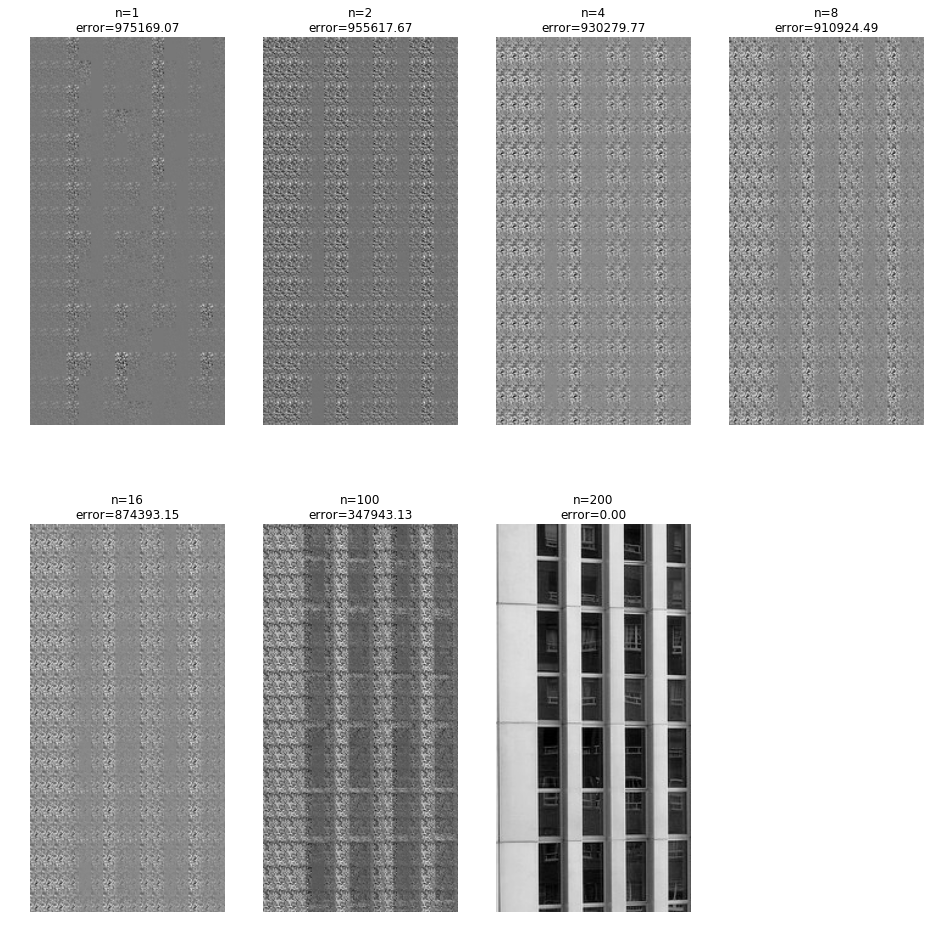

In [10]:
# (e)
img2 = Image.open("imgpca/b5.jpg")
matrix2 = []
for y in range(16) :
    for x in range(16) :
        matrix2.append(list(img2.crop((x*10,y*20,x*10+10,y*20+20)).getdata()))
matrix2 = np.array(matrix2)

(re_matrices2, errors2) = create_reconstructed_matrixes_and_erros(matrix2)
show_reconstruct_evolution(re_matrices2, errors2)

## 3.2 Oja’s Rule: Derivation (3 points)
Consider a linear connectionist neuron whose output $y = y(t)$ at time $t$ is an inner product of
the $N$-dim input vector $x = x(t)$ with the $N$-dim weight vector $w$:
$$ y = w^T x$$.
The Hebbian update rule for learning the weights can be written as
$$ w_i (t+1) = w_i (t) + \eta y (t)x_i(t), i =1,2,\ldots ,N $$
where, $\eta$ is the learning-rate parameter and $t$ the iteration step. As was shown in the lecture, the
Hebbian learning rule leads to a divergence of the length of the weight vector. Therefore, the
following normalization was introduced by *Oja*:
$$ w_i (t+1) = \frac{w_i (t) + \eta y (t) x_i (t)}{\sqrt{\left( \sum_{j=1}^{N} (w_j (t) + \eta y(t) x_j(t))^2 \right)}} $$

**Task:** Derive an approximation to this update rule for a small value of the learning-rate parameter $\eta$ by Taylor-expanding the right hand side of this equation with respect to $\eta$. Show that
neglecting terms of second or higher order in $\eta$ gives *Oja's* rule:
$$ w_i(t + 1) = w_i(t) + \eta y(t) \left[x_i(t) − y(t)w_i(t)\right] $$

## 3.3 Oja’s Rule: Application


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = np.loadtxt("data-onlinePCA.txt", delimiter=",", usecols=[1,2], skiprows=1)
#w = np.random.normal(loc=0.1, scale=.1, size=(2,1))
w = np.array([0.29963461, 0.1558236])


class PCA():
   def __init__(self, X):
      self.n, self.d = X.shape   #X row-wise points
      self.U, self.D = self.solveeigensystem(self.scatter(X))
   def project(self, X, m):
      Ureduce = self.U[0:m]     #row-wise eigenvectors
      Z = np.dot(Ureduce, self.center(X).T).T
      return Z
   def denoise(self, X, m):
      Ureduce = self.U[0:m]     #row-wise eigenvectors
      Xprime = self.decenter(np.dot(Ureduce.T, self.project(X, m).T).T)
      return Xprime
   def center(self, X):
      self.Xbar = (1.0/self.n) * (np.sum(X, axis=0)).T
      return X - self.Xbar
   def decenter(self, X):
      return X + self.Xbar
   def scatter(self, X):
      Xcentered = self.center(X)
      S = np.dot(Xcentered.T, Xcentered)
      return S
   def solveeigensystem(self, X):
      D, U = np.linalg.eigh(X)
      U = U.T[::-1]*-1              #eigen vectors are row-wise now
      D = D[::-1] / (self.n - 1)
      return U, D

1) Make a scatter plot of the data and indicate the time index by the color of the datapoints (you can e.g. break the full dataset into 10 blocks corresponding to 1 second length each and therefore use 10 different colors).

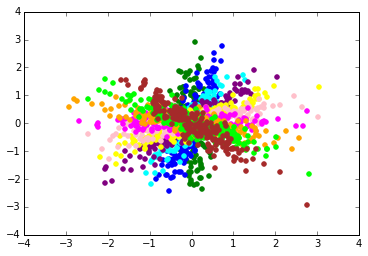

In [14]:
blocksize = len(X)/10
colors = ["green", "blue", "cyan", "purple", "yellow", "pink", "magenta", "orange", "lime", "brown"]

def plotpoints(X, blocksize, colors):
   for i in range(10):
      plt.scatter(X.T[0,i*blocksize:i*blocksize+blocksize], 
                  X.T[1, i*blocksize:i*blocksize+blocksize], 
                  color=colors[i])

plotpoints(X, blocksize, colors)
plt.show()


2) Determine the principal components (using batch PCA) and plot the first PC (e.g. as an arrow or the endpoint of it) in the same plot as the original data.

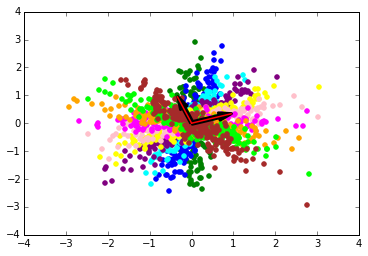

In [18]:
pca = PCA(X)

def plotpcs(pca):
   plt.quiver(pca.U[0,0],pca.U[0,1], color="black", linewidth=3, 
              scale_units='xy', angles='xy', scale=1)
   plt.quiver(pca.U[1,0],pca.U[1,1], color="black", linewidth=3, 
              scale_units='xy', angles='xy', scale=1)
   plt.plot([0, pca.U[0,0]],[0, pca.U[0,1]], color="red", linewidth=1.5)
   plt.plot([0, pca.U[1,0]],[0, pca.U[1,1]], color="red", linewidth=1.5)

plotpoints(X, blocksize, colors)
plotpcs(pca)
plt.show()
plt.close()


3) Implement Oja’s rule and apply it with a learning-rate parameter η ∈ {0.002, 0.04, 0.45} to the dataset. Plot the weights at each timestep (as points whose x vs. y coordinates are given by the weight for x and y) in the same plot as the original data (use the colors from 1. to indicate the time index for each plotted weight). Interpret your results.

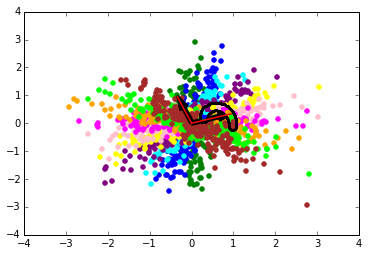

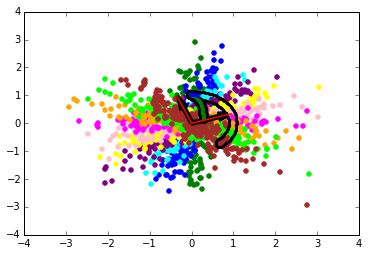

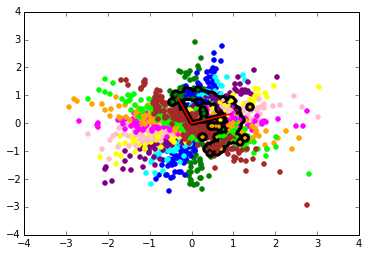

In [17]:
def oja_learning(data, initial_eta, initial_weights):
   w=[np.asarray(initial_weights)]
   eta = np.float(initial_eta)
   for x in data:
       y=np.dot(w[-1], x)            
       dw = eta*(x*y-(y**2)*w[-1])
       w.append(w[-1]+dw)
   return np.asarray(w)

def plotoja(X, eta, blocksize, colors, pca, w):
   plotpoints(X, blocksize, colors)
   plotpcs(pca)
   weights = oja_learning(X, eta, w)
   plt.scatter(weights.T[0], weights.T[1], color="black", linewidths=5.0)

   for i in range(10):
      plt.scatter(weights.T[0,i*blocksize:i*blocksize+blocksize], 
                  weights.T[1,i*blocksize:i*blocksize+blocksize], 
                  color=colors[i], marker=".")
      
   plt.show()

plotoja(X, .002, blocksize, colors, pca, w)
plotoja(X, .04, blocksize, colors, pca, w)
plotoja(X, .45, blocksize, colors, pca, w)
